# Heart failure outcome classifier
In this notebook we will take a dive into a [this](https://www.kaggle.com/datasets/asgharalikhan/mortality-rate-heart-patient-pakistan-hospital) dataset of heart failures in Pakistan.  
While I am **not** a medical professional and know only slightly more about heart failures than an average person, I will try to create a model, that will predict the mortality of a heart failure in the Pakistani settings. This model might not work to predict the mortality in other countries, which are more or less medically advanced. 

> **Disclaimer!** This is not a medical study nor recommendation!

## How will it work?
With hypothesis testing, I will determine, which of the features of the patients attribute to the heart failure the most to mortality. Having the best features selected, I will create a model, that will predict the mortality for the given sample of patients. Once the model is created with best possible scores, I will check and determine, which of the features impact mortality the most. 

## How is this model useful?
Knowing the most crucial features that might contribute to fatal heart failure, users of this model might check if in their current health, would they survive a heart failure in Pakistan. In another setting, if the model predicts fatality, whils the user is alive, it might be a suggestion to consult with their doctor the state of their health, to avoid heart failure in the future - this aspect might be useful in any different settings.

## Good to know
Data analized in this study does not touch on the accessability to the hospital or a doctor, time of diagnosis, CPR occurrecne and duration, threatment, how long did it take for the patient to receive firts aid, how far were they from the nearest hospital, chronic diseases, etc. While the dataset gives a good insight on the patients parameters, many life-saving aspects are not included, therefore any conclusions, especially resulting in death on a user of this model should not be taken too seriously. These might however suggest to schedule a check-up with the users doctor.

# Exploratory data analysis

In [1]:
# setting the environment
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

import optuna
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier


# there are many columns, I want to see them all
pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv('data/heart_failure_dataset.csv')

# column names are strangely formated, let's fix them quick
replace_dict = {}

for c in df.columns:
    if c not in replace_dict.keys():
        replace_dict[c] = c.replace(' ', '').replace('.', '')     
                                    
df = df.rename(columns=replace_dict)
df.head(5)

,Age,AgeGroup,Gender,Locality,Maritalstatus,LifeStyle,Sleep,Category,Depression,Hyperlipi,Smoking,FamilyHistory,FHistory,Diabetes,HTN,Allergies,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,Others,CO,Diagnosis,Hypersensitivity,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,SKReact,Reaction,Mortality,FollowUp
0,45,41-50,Female,RURAL,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,1,NO,NO,100.6,0,84,28.0,0.9,138,3.3,107,130,30,11,9900,4.26,11.6,0.34,79.7,27.2,0.34,265000,0.70,0.25,0.03,2,no,"Chest pain,",EXT. ACUTE WALL M.I,NO,4,132,341,1,2,136,1,3.0,2,0,7,2,1,NO,0,0,60
1,51,51-60,Female,URBAN,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,0,NO,NO,90.6,0,135,17.0,0.7,144,4.7,104,163,30,27,15800,5.74,14.5,0.44,78.0,25.0,0.32,287000,0.73,0.20,0.04,3,no,"Central Chest pain,",A/W M.I,NO,4,130,305,0,0,142,1,1.2,2,0,7,2,1,NO,0,0,15
2,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,100.7,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,LV dysfunction,"Chest pain,SOB, Cold sweating",AC I/W M.I (RV) RE. M.I,NO,4,180,327,0,1,117,1,3.4,2,0,3,2,1,NO,0,0,6
3,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,160.1,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,HTN,"CENTRAL Chest pain,",I/W M.I,NO,4,128,205,0,1,130,1,2.0,2,1,7,3,1,NO,0,0,52
4,56,51-60,Female,RURAL,MARRIED,YES,NO,FREE,YES,YES,NO,NO,0,1,YES,NO,90.6,0,85,78.0,1.2,139,4.5,112,75,18,13,6900,4.41,12.3,0.36,82.0,27.0,0.33,211000,0.71,0.25,0.02,2,no,"Chest pain,",A/W M.I,NO,4,200,288,1,2,133,1,4.0,3,2,7,3,1,NO,0,0,34


In [3]:
df.shape

(368, 60)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               368 non-null    int64  
 1   AgeGroup          368 non-null    object 
 2   Gender            368 non-null    object 
 3   Locality          368 non-null    object 
 4   Maritalstatus     368 non-null    object 
 5   LifeStyle         368 non-null    object 
 6   Sleep             368 non-null    object 
 7   Category          368 non-null    object 
 8   Depression        368 non-null    object 
 9   Hyperlipi         368 non-null    object 
 10  Smoking           368 non-null    object 
 11  FamilyHistory     368 non-null    object 
 12  FHistory          368 non-null    int64  
 13  Diabetes          368 non-null    int64  
 14  HTN               368 non-null    object 
 15  Allergies         368 non-null    object 
 16  BP                368 non-null    float64
 1

In [5]:
df.isna().sum().sum() # there are no NaN values in the dataset

0

In [6]:
# FamilyHistory is the same as FHistory, just not encoded, let's drop it
df = df.drop('FamilyHistory', axis=1)

In [7]:
df.duplicated().sum() # seems there is a lot of duplicates

214

In [8]:
mortality_percentage = df['Mortality'].value_counts(normalize=True) * 100
mortality_percentage

0    78.26087
1    21.73913
Name: Mortality, dtype: float64

Upon further inspection of the dataset, majority of rows are duplicated, which is unfortunate, as this dataset it pretty small.

The differences between the statistics of the dataset with and without the duplicates are similar, and with the duplicates the percentage of patients, who survided the heart failure is larger - this makes the data less unbalanced. 

For the modeling, we will use the dataset with the duplicates, since most of the data is distibuted the same, however for hypothesis testing we will only compare the dataset without the duplicates, so that these will not affect the differences.

In [9]:
# let's create a copy - a clear dataset
df_c = df.copy()
df_c = df_c.drop_duplicates()

In [10]:
# let's check the mortality rate in clean dataset
mortality_percentage_c = df_c['Mortality'].value_counts(normalize=True) * 100
mortality_percentage_c

0    82.467532
1    17.532468
Name: Mortality, dtype: float64

In [11]:
df_c.describe() # now that duplicates are gone, let's see how our data looks

,Age,FHistory,Diabetes,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,Reaction,Mortality,FollowUp
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,55.772727,0.194805,0.409091,118.165779,0.051948,227.948052,47.135714,1.490000,137.987013,4.194805,103.461039,637.694805,69.396104,25.720779,11171.363636,5.115325,13.840260,0.417208,81.033766,27.059740,0.326753,245792.207792,2.294286,0.249026,0.033117,2.214286,3.590909,133.396104,249.448052,0.149351,1.162338,139.993506,0.551948,1.531169,1.818182,1.051948,5.896104,2.032468,0.974026,0.759740,0.175325,28.902597
std,9.036978,0.397343,0.493270,23.459274,0.222646,141.137804,54.496293,3.079576,3.993437,0.369559,4.628885,1085.768192,100.175233,28.377358,3360.261441,0.775705,2.162319,0.065744,7.304875,3.330735,0.027839,78208.509251,11.413506,0.117366,0.015946,0.877938,0.844928,18.592788,49.913133,0.357597,0.980001,22.523915,0.498917,1.300403,0.565391,1.027671,1.715629,1.012464,0.159577,0.428635,0.381485,16.567457
min,24.000000,0.000000,0.000000,80.500000,0.000000,60.000000,2.300000,0.600000,129.000000,3.300000,90.000000,52.000000,14.000000,5.000000,5800.000000,3.460000,9.100000,0.290000,60.000000,18.000000,0.220000,20000.000000,0.360000,0.050000,0.010000,1.000000,1.000000,100.000000,131.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,52.000000,0.000000,0.000000,100.625000,0.000000,127.000000,28.000000,0.800000,135.000000,3.900000,100.000000,131.250000,22.000000,11.000000,7900.000000,4.410000,12.300000,0.360000,78.000000,25.000000,0.320000,187000.000000,0.600000,0.170000,0.020000,2.000000,4.000000,120.000000,213.000000,0.000000,0.000000,125.000000,0.000000,0.225000,1.000000,0.000000,3.750000,1.000000,1.000000,1.000000,0.000000,15.000000
50%,57.000000,0.000000,0.000000,120.700000,0.000000,165.000000,35.500000,0.900000,138.000000,4.200000,104.000000,192.000000,39.000000,16.000000,10400.000000,5.230000,14.100000,0.420000,82.100000,27.800000,0.330000,237000.000000,0.720000,0.210000,0.030000,2.000000,4.000000,130.000000,248.500000,0.000000,2.000000,142.000000,1.000000,1.400000,2.000000,1.000000,7.000000,2.000000,1.000000,1.000000,0.000000,32.000000
75%,61.000000,0.000000,1.000000,130.800000,0.000000,320.000000,42.000000,1.080000,140.750000,4.400000,106.000000,446.000000,52.000000,27.000000,13800.000000,5.650000,15.500000,0.460000,86.000000,29.000000,0.340000,284000.000000,0.797500,0.320000,0.040000,3.000000,4.000000,143.500000,283.000000,0.000000,2.000000,156.750000,1.000000,2.475000,2.000000,2.000000,7.000000,3.000000,1.000000,1.000000,0.000000,36.000000
max,77.000000,1.000000,1.000000,190.110000,1.000000,563.000000,394.000000,22.900000,146.000000,5.300000,112.000000,4289.000000,505.000000,154.000000,19590.000000,6.980000,18.000000,0.540000,96.000000,33.000000,0.390000,459000.000000,83.000000,0.540000,0.080000,5.000000,4.000000,200.000000,409.000000,1.000000,2.000000,195.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000,1.000000,1.000000,60.000000


In [12]:
def outliers(dataframe, column):
    outliers = []
    q1 = np.percentile(sorted(dataframe[column]), 25)
    q3 = np.percentile(sorted(dataframe[column]), 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    for i in sorted(dataframe[column]): 
        if (i < lwr_bound or i > upr_bound):
            outliers.append(i)
    return outliers, lwr_bound, upr_bound

In [19]:
# let's see how do the outliers look
numeric_columns = df_c.select_dtypes(include=['int64', 'float64']).columns.tolist()
outlier_dict = {}

for c in numeric_columns:
    empty = []
    outlier = outliers(df_c, c)[0]
    if outlier != empty:
        outlier_dict[c] = outliers(df, c), len(outliers(df, c)[0])
        
print(outlier_dict.keys())

dict_keys(['Age', 'FHistory', 'BP', 'Thrombolysis', 'BUrea', 'SCr', 'SPotassium', 'SChloride', 'CPK', 'CKMB', 'ESR', 'MCV', 'MCH', 'MCHC', 'PLATELET_COUNT', 'NEUTROPHIL', 'MONOCYTE', 'EOSINO', 'cp', 'trestbps', 'chol', 'fbs', 'thalach', 'oldpeak', 'SK', 'Reaction', 'Mortality'])


In [22]:
numeric_columns

['Age',
 'FHistory',
 'Diabetes',
 'BP',
 'Thrombolysis',
 'BGR',
 'BUrea',
 'SCr',
 'SSodium',
 'SPotassium',
 'SChloride',
 'CPK',
 'CKMB',
 'ESR',
 'WBC',
 'RBC',
 'Hemoglobin',
 'PCV',
 'MCV',
 'MCH',
 'MCHC',
 'PLATELET_COUNT',
 'NEUTROPHIL',
 'LYMPHO',
 'MONOCYTE',
 'EOSINO',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'num',
 'SK',
 'Reaction',
 'Mortality',
 'FollowUp']

It seems there is a bit of outliers, but this should be examined by a medical professional.
In my unprofessional opinion with help from google, all of those should slide, since these are possible to be observed. Some of these, especially really high or really low values might be correlated with the mortality of the heart failure. Also in some cases, like Mortality, majority of the results is `0`, which suggest the death of the patients, therefore any that are `1`, in other words alive, are the outliers.
## Hypothesis testing
Before we move on with hypothesis testing, it's best to clean up some of the columns in the dataset, so that the messiness does not affect the outcome.

In [14]:
# Feature CO is very messy and all of the patients experience chest pain, so it can be removed
df_c['CO'] = df_c['CO'].str.lower() \
                   .str.replace(r'central|chest pain,|day|to|hr|for|from|chest pain', '') \
                   .str.strip()

# and filling in the empty spaces
df_c['CO'].replace('', 'none', inplace=True)
df_c.head()

/var/folders/71/prqs97ps2_lg_s37pr_lsd1h0000gn/T/ipykernel_45913/3979308016.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace(r'central|chest pain,|day|to|hr|for|from|chest pain', '') \


,Age,AgeGroup,Gender,Locality,Maritalstatus,LifeStyle,Sleep,Category,Depression,Hyperlipi,Smoking,FHistory,Diabetes,HTN,Allergies,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,Others,CO,Diagnosis,Hypersensitivity,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,SKReact,Reaction,Mortality,FollowUp
0,45,41-50,Female,RURAL,MARRIED,NO,NO,FREE,YES,YES,NO,0,1,NO,NO,100.6,0,84,28.0,0.9,138,3.3,107,130,30,11,9900,4.26,11.6,0.34,79.7,27.2,0.34,265000,0.70,0.25,0.03,2,no,none,EXT. ACUTE WALL M.I,NO,4,132,341,1,2,136,1,3.0,2,0,7,2,1,NO,0,0,60
1,51,51-60,Female,URBAN,MARRIED,NO,NO,FREE,YES,YES,NO,0,0,NO,NO,90.6,0,135,17.0,0.7,144,4.7,104,163,30,27,15800,5.74,14.5,0.44,78.0,25.0,0.32,287000,0.73,0.20,0.04,3,no,none,A/W M.I,NO,4,130,305,0,0,142,1,1.2,2,0,7,2,1,NO,0,0,15
2,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,0,1,YES,NO,100.7,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,LV dysfunction,"sob, cold sweating",AC I/W M.I (RV) RE. M.I,NO,4,180,327,0,1,117,1,3.4,2,0,3,2,1,NO,0,0,6
3,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,0,1,YES,NO,160.1,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,HTN,none,I/W M.I,NO,4,128,205,0,1,130,1,2.0,2,1,7,3,1,NO,0,0,52
4,56,51-60,Female,RURAL,MARRIED,YES,NO,FREE,YES,YES,NO,0,1,YES,NO,90.6,0,85,78.0,1.2,139,4.5,112,75,18,13,6900,4.41,12.3,0.36,82.0,27.0,0.33,211000,0.71,0.25,0.02,2,no,none,A/W M.I,NO,4,200,288,1,2,133,1,4.0,3,2,7,3,1,NO,0,0,34


In [15]:
# others column is also messy and requires clean up
df_c['Others'] = df_c['Others'].replace(r',\s*|,', ', ', regex=True)

When it comes to `Diagnosis`, I do not understand a letter in here. 
At work, I would ask someone with medical background to group these. Since I am doing this alone, I asked ChatGPT to group these and it distinuished a 5 types:
- myocardial infarctions (MI)
- NSTEMI (Atypical ST elevation during infarction)
- STEMI (ST elevation during infarction)
- other types of heart attacks
- other diagnosis (not cardiac arrest)  

Most of these are cardiac arrests, but in medical aspects are slighly different. 

In [16]:
# Let's group it
for diagnosis in df_c['Diagnosis'].unique():
    if "M.I" in diagnosis or "ACUTE" in diagnosis:
        # myocardial infarctions (MI)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'MI'
    elif "NSTEMI" in diagnosis:
        # NSTEMI (Atypical ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'NSTEMI'
    elif "STEMI" in diagnosis:
        # STEMI (ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'STEMI'
    elif "CARDIOGENIC" in diagnosis or "MR" in diagnosis or "LBBB" in diagnosis:
        # other diagnosis (not cardiac arrest)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'OTHER'
    else:
        # other types of heart attacks
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'OTHER MI'

### Defining the hipothesis
In this study, I will compare each column, one by one with Mortality, to determine, which of the data could give us more insight, on what really differenciates the individuals who survived their heart failure from those who did not. 

To begin, let's state our hipothesis:

$H_{0}$ = There is no statistically significant difference between Mortality and other column.

$H_{a}$ = There is a statistically significant difference between Mortality and other column.

We will keep only the columns that reject the $H_{0}$, as those are the ones that most significantly affect the Mortality (at least, statistically and within our data). 

In this case, we are interested in a two-tailed tests, since we do not really care if each specific means are greater or lower from each other, but if they are significantly different.

Upon earlier trials and errors, I decided that the significance level should be **0.1**, and therefore the confidence interval will be **90%**. Although in medical data we would rather aim at the greatest possible confidence interval to call a model successful, however this is also not the end of modeling.  

For categorical data, we will conduct a chi-square test, to determine how different the spread is in those cases for mortality, and for numeric columns we will compare the means in t-test.

In [24]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# numeric columns were already created, but we need to remove the target
numeric_columns.remove('Mortality')

In [25]:
# let's define our chi_square test and t_test for faster processing
def chi_square_test(dataframe, binary_column, categorical_column):
    contingency_table = pd.crosstab(dataframe[binary_column], dataframe[categorical_column])
    hi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    return p_value


def t_test(dataframe, binary_column, numeric_column):
    group1 = dataframe[dataframe[binary_column] == 0][numeric_column]
    group2 = dataframe[dataframe[binary_column] == 1][numeric_column]

    statistic, p_value = ttest_ind(group1, group2)

    return p_value

In [62]:
significant_columns = [] #list of significant columns

alpha = 0.1 # significance level

for column in categorical_columns:
    p_value = chi_square_test(df_c, 'Mortality', column)
    if p_value <= alpha:
        significant_columns.append(column)

pvalues = []
for column in numeric_columns:
    p_value = t_test(df_c, 'Mortality', column)
    if p_value <= alpha:
        significant_columns.append(column)
        pvalues.append([column, p_value])

/var/folders/71/prqs97ps2_lg_s37pr_lsd1h0000gn/T/ipykernel_45913/112811115.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, p_value = ttest_ind(group1, group2)


In [29]:
significant_columns

['AgeGroup',
 'Gender',
 'Smoking',
 'HTN',
 'Others',
 'SKReact',
 'Age',
 'FHistory',
 'Diabetes',
 'WBC',
 'oldpeak',
 'ca',
 'Reaction',
 'FollowUp']

Now with `significant_columns` in mind, we understand, that these features are the most different ones between alive and dead patients (at least - statistically). Our confidence in it is 90%.

To move forward, we will trim the dataset to only use these features, but we will use the dataset **with** duplicates - since we only have 154 unique records, this might be slightly to small number for our models to train on, but we also do not want to use skewed data.

To ensure it is okay to use data with duplicates, we will follow up with additional hypothesis testing:

$H_{0}$ = Mortality rate in dataset with and without duplicates is the same;

$H_{a}$ = Mortality rate in dataset with and without duplicates is the same.

Our significance level in this case will be **0.05** and therefore the confidence interval will be **95%**. We will take the results `1`, in other words `alive` as the defining one.

If the $H_{0}$ shall be rejected, we won't be using the dataset with duplicates.

In this case, I will be using proportions ztest, since the dataframes differ in sizes and slightly differ in proportions.

In [48]:
# list without duplicates
mortality_rate = len(df_c[df_c['Mortality'] == 1])
mortality_size = len(df_c['Mortality'])


# list with duplicates
mortality_rate_dupes = len(df[df['Mortality'] == 1])
mortality_size_dupes = len(df['Mortality'])

In [52]:
n_alive = np.array([mortality_rate, mortality_rate_dupes])
n_patients = np.array([mortality_size, mortality_size_dupes])

In [55]:
from statsmodels.stats.proportion import proportions_ztest

z_score, p_value = proportions_ztest(count=n_alive, 
                                     nobs=n_patients,
                                     alternative='two-sided')
print(f'p-value: {p_value}')

p-value: 0.2775769366445243


Since the p-value is larger than our 5% significance level, hence we sustain the $H_{0}$.

As a result, we can use the dataframe `df`, where we kept the duplicated values, so our models have more informations to learn from. Hurray!

### Data preparation and encoding
For any further analysis we need to encode all categorical data.

In [63]:
# we cannot miss out target value
significant_columns.append('Mortality')

# since we want the age group to have good encoding, it will be best if we sort by 'Age'
df = df[significant_columns].sort_values(by='Age')

df.head()

,AgeGroup,Gender,Smoking,HTN,Others,SKReact,Age,FHistory,Diabetes,WBC,oldpeak,ca,Reaction,FollowUp,Mortality
139,21-30,Female,NO,YES,no,NO,24,0,1,10900,1.6,0,0,1,0
252,21-30,Male,NO,NO,no,COUGH.BLEEDING,24,0,0,7800,1.6,0,1,5,0
25,21-30,Male,NO,NO,no,COUGH.BLEEDING,24,0,0,7800,1.6,0,1,5,0
341,21-30,Male,NO,NO,no,COUGH.BLEEDING,24,0,0,7800,1.6,0,1,5,0
189,21-30,Male,NO,NO,no,COUGH.BLEEDING,24,0,0,7800,1.6,0,1,5,0


In [68]:
binary_columns = ['Smoking', 'HTN']

binary_map = {'NO': 0, 'YES': 1}

label_enc_columns = ['AgeGroup', 'Gender', 'SKReact', 'Others']

In [66]:
# encoding binary columns
df[binary_columns] = df[binary_columns].replace(binary_map)

In [69]:
labeler = LabelEncoder() # here we do not need to define anything inside
labels_dict = {} # for the future reference

for column in label_enc_columns:
    df[column] = labeler.fit_transform(df[column])
    if column not in labels_dict.keys():
        labels_dict[column] = dict(zip(labeler.transform(labeler.classes_), labeler.classes_))

In [84]:
# so we keep it originally sorted
df = df.sort_index()
df.head()

,AgeGroup,Gender,Smoking,HTN,Others,SKReact,Age,FHistory,Diabetes,WBC,oldpeak,ca,Reaction,FollowUp,Mortality
0,2,0,0,0,16,4,45,0,1,9900,3.0,0,0,60,0
1,3,0,0,0,16,4,51,0,0,15800,1.2,0,0,15,0
2,3,0,0,1,11,4,55,0,1,7900,3.4,0,0,6,0
3,3,0,0,1,5,4,55,0,1,7900,2.0,1,0,52,0
4,3,0,0,1,16,4,56,0,1,6900,4.0,2,0,34,0


Hurray, we cleaned and encoded the data! 🥳

## PCA

In [70]:
# for PCA we need to scale and center our data
scaler = StandardScaler()

# copying so not to scale all data at once
dff = df.copy() 

# transformation
dff = scaler.fit_transform(dff) 

In [71]:
pca = PCA()
pca.fit(dff)

PCA()

In [72]:
threshold = 0.95

cumulative_var = np.cumsum(pca.explained_variance_ratio_)
cumulative_var

array([0.26026356, 0.39873149, 0.48970554, 0.57724492, 0.65380566,
       0.71999535, 0.78089136, 0.83181495, 0.87661695, 0.91830453,
       0.95160559, 0.97377413, 0.98956345, 0.9951497 , 1.        ])

In [73]:
components_number = np.argmax(cumulative_var > threshold)
print(f'The number of components explaining {threshold:.0%} of the variance: {components_number}')

The number of components explaining 95% of the variance: 10


In [76]:
print(f'{pca.explained_variance_ratio_[0]:.2%} of the data variance has been preserved along the first principal component,')
print(f'{pca.explained_variance_ratio_[1]:.2%} of the data variance has been preserved along the second principal component, etc.')

26.03% of the data variance has been preserved along the first principal component,
13.85% of the data variance has been preserved along the second principal component, etc.


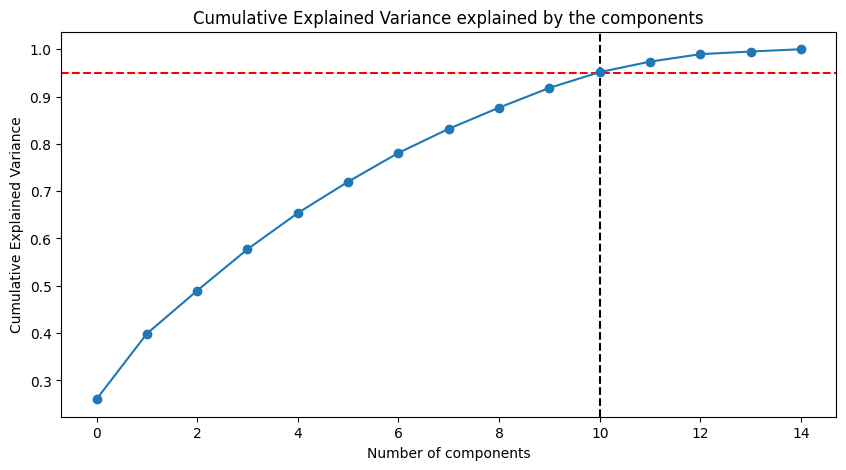

In [77]:
plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of components')
plt.axvline(x=components_number, color="k", linestyle="--")
plt.axhline(y=threshold, color="r", linestyle="--")
plt.plot(cumulative_var, marker='o')
plt.show()

Based on the Principal Components Analysis we can conclude that statistically, we would get should get quite good reluts if we only take 10 features into consideration. 

However, since this dataset is already trimmed by a lot by using hypothesis testing, I will keep all the features when creating our model (or rather concoction of three models) and later decide if it could be trimmed further with feature importances. 

### Model creation

In [92]:
# firstly let's create some useful functions

def calculate_metrics(target, prediction, average='macro'):
    '''
    With this function we generate all metrics we want to check for classification problem
    '''
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average, zero_division = 0)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    roc = roc_auc_score(target, prediction)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, roc, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    '''
    With this function we are printing all the metrics
    '''
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  ROC score: {metrics[4]}')
    print(f'  Mislabeled {metrics[5]} out of {metrics[6]}')
    
    
def get_binary_classes(y):
    '''
    With this function we print out the original proporions of 0 and 1 in the subset
    '''
    zeros = len([x for x in y if x == 0])
    ones = len([x for x in y if x == 1])
    print(f'Quantities are {zeros} for 0, {ones} for 1')
    print('\n')
    
def get_confusion_matrix(y, y_pred):
    '''
    This function returns a visualization of a confusion matrix
    '''
    fig, ax = plt.subplots(figsize=(3,3))
    cm = confusion_matrix(y, y_pred)
    ax = sns.heatmap(cm, annot = True, fmt = 'd')
    plt.show()

In [87]:
y = df.pop('Mortality') # target
X = df

In [93]:
# splitting into train and test, validation will be split later, in cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y
                                                   )

Results for 1
----
  Accuracy:  0.9322033898305084
  Precision: 0.8997252747252746
  Recall:    0.8233333333333333
  F1 score:  0.8553921568627452
  ROC score: 0.8233333333333333
  Mislabeled 4 out of 59
Quantities are 50 for 0, 9 for 1




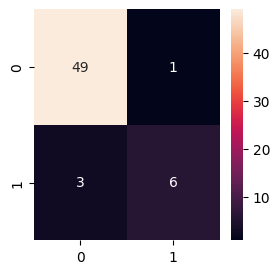

Results for 2
----
  Accuracy:  0.8135593220338984
  Precision: 0.8981481481481481
  Recall:    0.65625
  F1 score:  0.6813942071674031
  ROC score: 0.65625
  Mislabeled 11 out of 59
Quantities are 43 for 0, 16 for 1




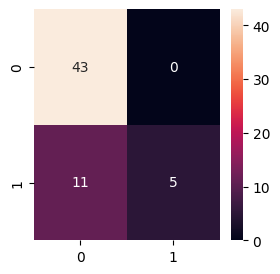

Results for 3
----
  Accuracy:  0.8135593220338984
  Precision: 0.7055555555555555
  Recall:    0.7452651515151515
  F1 score:  0.7208602150537635
  ROC score: 0.7452651515151514
  Mislabeled 11 out of 59
Quantities are 48 for 0, 11 for 1




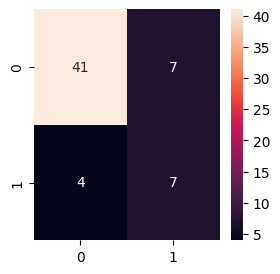

Results for 4
----
  Accuracy:  0.9491525423728814
  Precision: 0.96875
  Recall:    0.8928571428571428
  F1 score:  0.9238709677419354
  ROC score: 0.8928571428571428
  Mislabeled 3 out of 59
Quantities are 45 for 0, 14 for 1




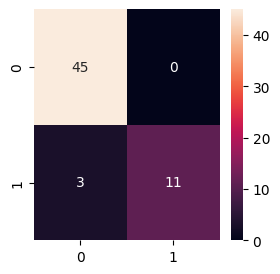

Results for 5
----
  Accuracy:  0.9655172413793104
  Precision: 0.9395833333333333
  Recall:    0.9395833333333333
  F1 score:  0.9395833333333333
  ROC score: 0.9395833333333333
  Mislabeled 2 out of 58
Quantities are 48 for 0, 10 for 1




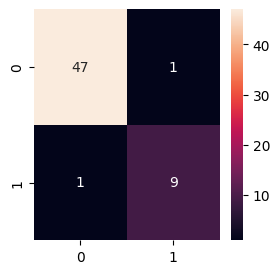

In [94]:
kfoldcv = KFold(n_splits=5,
                shuffle=True,
                random_state=42
               )

# let's try on vanilla AdaBoost
for n, (train, val) in enumerate(kfoldcv.split(X_train, y_train), 1):
    X_train_fold, y_train_fold = X.iloc[train], y.iloc[train]
    X_val_fold, y_val_fold = X.iloc[val], y.iloc[val]
    
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.fit_transform(X_val_fold)
    
    abc = AdaBoostClassifier()
    abc.fit(X_train_scaled, y_train_fold)
    y_pred = abc.predict(X_val_scaled)
    
    print_results(calculate_metrics(y_val_fold, y_pred), classifier_id=n)
    get_classes(y_val_fold)
    get_confusion_matrix(y_val_fold, y_pred)

Results for classifier
----
  Accuracy:  0.9594594594594594
  Precision: 0.9754098360655737
  Recall:    0.90625
  F1 score:  0.9356708200521588
  ROC score: 0.90625
  Mislabeled 3 out of 74
Quantities are 58 for 0, 16 for 1




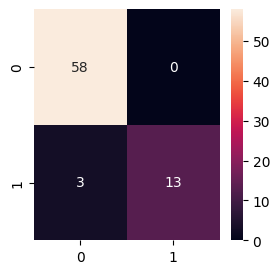

In [95]:
# let's test it on test data, which the model has not seen before
X_test_scaled = scaler.fit_transform(X_test)
y_test_pred = abc.predict(X_test_scaled)

print_results(calculate_metrics(y_test, y_test_pred))
get_classes(y_test)
get_confusion_matrix(y_test, y_test_pred)

I do use quite a lot of metrics here, however the ones that interest me the most are **ROC score**, **F1 score** and **Accuracy**. I am also analyzing the confusion matrices, to know where the mistakes are generated most often. 

This vanilla `AdaBoostClassifier` did quite a good job actually, better than I expected. Also, taking into consideration the results cross validation, it seems that the predictions in all cases are not random. 

In [66]:
# Metrics are not consistent, perhaps let's see, if there are better hyperparameters


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      random_state=42,
                                                      stratify=y_train
                                                     )

def objective(trial):

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.fit_transform(X_val)
    

    n_estimators = trial.suggest_int('n_estimators', 100,600)
    learning_rate = trial.suggest_float('learning_rate', 0.001,1)
 

    xbg2 = AdaBoostClassifier(
                               n_estimators=n_estimators,
                               learning_rate=learning_rate
                              )

    xbg2.fit(X_train_scaled, y_train)
    y_pred_val = xbg2.predict(X_val_scaled)
    roc = roc_auc_score(y_val, y_pred_val)
    return roc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-09-24 22:40:12,700] A new study created in memory with name: no-name-0460de0b-4922-4ec2-ae2a-eaabf4439929
[I 2023-09-24 22:40:13,129] Trial 0 finished with value: 0.7933333333333332 and parameters: {'n_estimators': 568, 'learning_rate': 0.9987549665834048}. Best is trial 0 with value: 0.7933333333333332.
[I 2023-09-24 22:40:13,566] Trial 1 finished with value: 0.7933333333333332 and parameters: {'n_estimators': 597, 'learning_rate': 0.7015264138127344}. Best is trial 0 with value: 0.7933333333333332.
[I 2023-09-24 22:40:13,944] Trial 2 finished with value: 0.7933333333333332 and parameters: {'n_estimators': 512, 'learning_rate': 0.4360565118767118}. Best is trial 0 with value: 0.7933333333333332.
[I 2023-09-24 22:40:14,060] Trial 3 finished with value: 0.8133333333333332 and parameters: {'n_estimators': 150, 'learning_rate': 0.19613714050286604}. Best is trial 3 with value: 0.8133333333333332.
[I 2023-09-24 22:40:14,495] Trial 4 finished with value: 0.73 and parameters: {'n_est

In [67]:
best_params = study.best_params
best_params

{'n_estimators': 150, 'learning_rate': 0.19613714050286604}

Results for 1
----
  Accuracy:  0.7368421052631579
  Precision: 0.5729166666666666
  Recall:    0.5583333333333333
  F1 score:  0.5622119815668203
  ROC score: 0.5583333333333335
  Mislabeled 5 out of 19


Quantities are 15 for 0, 4 for 1


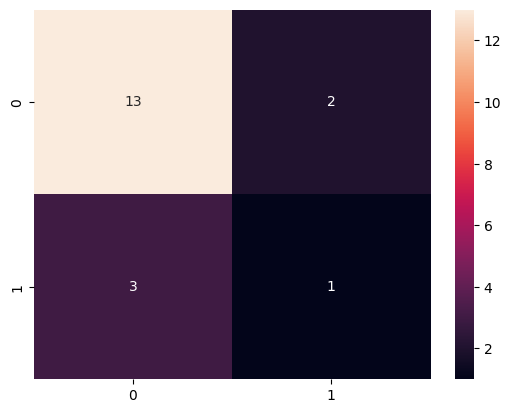

Results for 2
----
  Accuracy:  0.6842105263157895
  Precision: 0.40625
  Recall:    0.40625
  F1 score:  0.40625
  ROC score: 0.40625
  Mislabeled 6 out of 19


Quantities are 16 for 0, 3 for 1


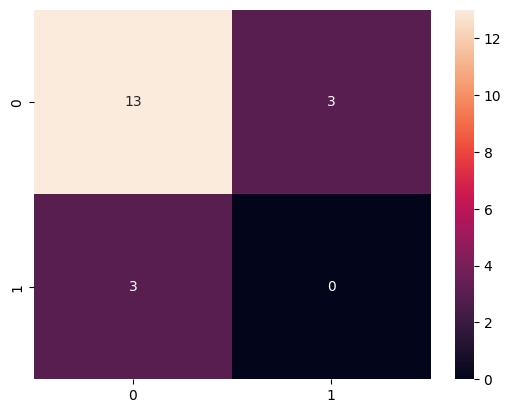

Results for 3
----
  Accuracy:  0.7777777777777778
  Precision: 0.8823529411764706
  Recall:    0.6
  F1 score:  0.6
  ROC score: 0.6
  Mislabeled 4 out of 18


Quantities are 13 for 0, 5 for 1


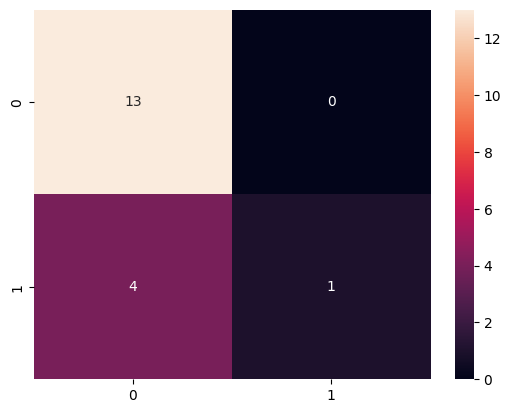

Results for 4
----
  Accuracy:  0.9444444444444444
  Precision: 0.9705882352941176
  Recall:    0.75
  F1 score:  0.8181818181818181
  ROC score: 0.75
  Mislabeled 1 out of 18


Quantities are 16 for 0, 2 for 1


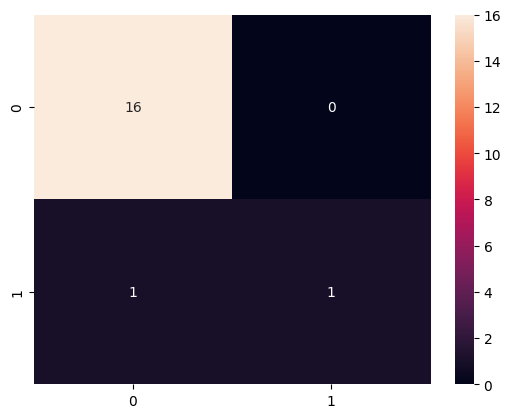

Results for 5
----
  Accuracy:  0.6666666666666666
  Precision: 0.5178571428571428
  Recall:    0.5178571428571428
  F1 score:  0.5178571428571428
  ROC score: 0.5178571428571428
  Mislabeled 6 out of 18


Quantities are 14 for 0, 4 for 1


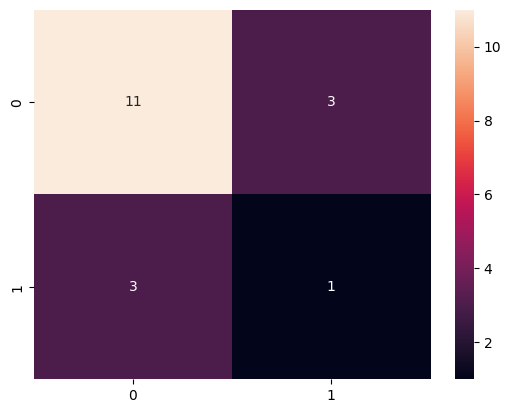

In [68]:
for n, (train, val) in enumerate(kfoldcv.split(X_train, y_train), 1):
    X_train_fold, y_train_fold = X.iloc[train], y.iloc[train]
    X_val_fold, y_val_fold = X.iloc[val], y.iloc[val]
    
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.fit_transform(X_val_fold)
    
    best_params = study.best_params
    ada = AdaBoostClassifier(
                         n_estimators=best_params['n_estimators'],
                         learning_rate=best_params['learning_rate']
                              )    
                              
    ada.fit(X_train_scaled, y_train_fold)
    y_pred = ada.predict(X_val_scaled)
    
    print_results(calculate_metrics(y_val_fold, y_pred), classifier_id=n)
    get_classes(y_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd')
    plt.show()

In [69]:
adaboost_model = AdaBoostClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Trenuj modele na danych treningowych
adaboost_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Dokonaj predykcji na danych testowych
adaboost_predictions = adaboost_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# Uśrednij predykcje z obu modeli
average_predictions = np.mean([adaboost_predictions, xgb_predictions], axis=0)

# Oblicz AUC-ROC dla predykcji uśrednionych
roc_auc_average = roc_auc_score(y_test, average_predictions)

print("AUC-ROC Score for Averaged Predictions:", roc_auc_average)

AUC-ROC Score for Averaged Predictions: 0.8384615384615384


In [70]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# Inicjalizuj modele
adaboost_model = AdaBoostClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Kombinuj predykcje z kilku modeli (ensemble)
def combine_predictions(models, X):
    predictions = np.zeros((len(X),))
    for model in models:
        predictions += model.predict(X)
    return predictions / len(models)

# Lista modeli do uwzględnienia w ensemble
ensemble_models = [adaboost_model, xgb_model]

# Inicjalizuj scalera
scaler = StandardScaler()

# Inicjalizuj KFold
kfoldcv = KFold(n_splits=4, random_state=42, shuffle=True)

# Pętla walidacyjna
for n, (train, val) in enumerate(kfoldcv.split(X_train, y_train), 1):
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    X_val_fold, y_val_fold = X_train.iloc[val], y_train.iloc[val]
    
    # Skaluj dane
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)
    
    # Trenuj modele
    models_predictions = []
    for model in ensemble_models:
        model.fit(X_train_scaled, y_train_fold)
        models_predictions.append(model.predict(X_val_scaled))
    
    # Kombinuj predykcje modeli
    combined_predictions = combine_predictions(ensemble_models, X_val_scaled)
    combined_predictions[combined_predictions == 0.5] = 1
    
    # Oblicz AUC-ROC dla uśrednionych predykcji
    roc_auc_combined = roc_auc_score(y_val_fold, combined_predictions)
    combined_f1_score = f1_score(y_val_fold, combined_predictions)
    
    print("AUC-ROC Score for Combined Predictions:", roc_auc_combined)
    print("F1 Score for Combined Predictions:", combined_f1_score)

AUC-ROC Score for Combined Predictions: 0.5723684210526316
F1 Score for Combined Predictions: 0.28571428571428575
AUC-ROC Score for Combined Predictions: 0.4950980392156863
F1 Score for Combined Predictions: 0.2
AUC-ROC Score for Combined Predictions: 0.5723684210526316
F1 Score for Combined Predictions: 0.28571428571428575
AUC-ROC Score for Combined Predictions: 0.726190476190476
F1 Score for Combined Predictions: 0.5


In [155]:
combined_predictions

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])

In [71]:
feat_importance_ada = adaboost_model.feature_importances_

# Tworzenie DataFrame z ważnością cech
feat_importance_ada_df = pd.DataFrame({'Feature': X.columns, 'Importance': feat_importance_ada})
feat_importance_ada_df = feat_importance_ada_df.sort_values(by='Importance', ascending=False)

print("AdaBoost Feature Importance:")
print(feat_importance_ada_df)

AdaBoost Feature Importance:
     Feature  Importance
5        Age        0.24
9    oldpeak        0.20
1     Gender        0.10
12  FollowUp        0.10
0   AgeGroup        0.08
8        WBC        0.08
10        ca        0.08
2    Smoking        0.06
4    SKReact        0.04
6   FHistory        0.02
3        HTN        0.00
7   Diabetes        0.00
11  Reaction        0.00


In [72]:
feat_importance_xgb = xgb_model.feature_importances_

# Tworzenie DataFrame z ważnością cech
feat_importance_xgb_df = pd.DataFrame({'Feature': X.columns, 'Importance': feat_importance_xgb})
feat_importance_xgb_df = feat_importance_xgb_df.sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance:")
print(feat_importance_xgb_df)

XGBoost Feature Importance:
     Feature  Importance
1     Gender    0.316835
10        ca    0.129222
5        Age    0.121416
8        WBC    0.087971
0   AgeGroup    0.083610
9    oldpeak    0.071840
12  FollowUp    0.069294
7   Diabetes    0.043132
2    Smoking    0.040909
4    SKReact    0.035772
3        HTN    0.000000
6   FHistory    0.000000
11  Reaction    0.000000
